In [1]:
import sys
sys.path.append('../../scripts/')
from matplotlib.colors import Normalize, CenteredNorm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
#plt.style.use('seaborn-talk') 
plt.style.use('seaborn-v0_8-talk')
from load_SAIdata import Cases
from xarray_funcs import wmean
import cmocean
import cartopy.crs as ccrs
from dask.distributed import LocalCluster, Client
from dask.diagnostics import ProgressBar
import numpy as np
import xarray as xr
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
VAR = 'TREFHT'
DASK_NUM = 1e6 # optimal number of element in dask chunk

In [3]:
# initiate dask cluster for parallel computing
cluster = LocalCluster(n_workers=8) #n_workers=16, threads_per_worker=1, memory_limit="14GiB", processes=True)
client = Client(cluster)
cluster, client

(LocalCluster(25d692cd, 'tcp://127.0.0.1:35741', workers=8, threads=16, memory=28.00 GiB),
 <Client: 'tcp://127.0.0.1:35741' processes=8 threads=16, memory=28.00 GiB>)

In [4]:
# def center_time(ds):
#     """set time stamps to center of time_bnds"""
#     time = ('time', ds.time_bnds.mean('nbnd').data, ds.time.attrs)
#     ds = ds.assign_coords({'ctime':time}).swap_dims({'time':'ctime'})
#     return ds.drop_vars('time').rename({'ctime':'time'})


# def shift_time(ds, ndays):
#     """shift time of dataset by ndays days"""
#     dt = datetime.timedelta(days=ndays)
#     t0, t1 = ds.time.data[[0,-1]]
#     print(f"Shifting time period from {t0}--{t1} to {t0+dt}--{t1+dt}")
#     ds = ds.assign(time_bnds=(ds.time_bnds.dims,(ds.time_bnds.compute()+dt).data,ds.time_bnds.attrs))
#     return ds.assign(time=(ds.time.dims,(ds.time+dt).data,ds.time.attrs))

In [5]:
Cases.cases

{'lres.spinup': '/projects/0/prace_imau/prace_2013081679/cesm1_0_4/f09_g16/spinup_pd_maxcores_f09_g16/OUTPUT',
 'lres.sai20': '/projects/0/nwo2021025/archive/lres_b.e10.B2000_CAM5.f09_g16.feedforward.001',
 'lres.sai': '/projects/0/nwo2021025/archive/lres_b.e10.B2000_CAM5.f09_g16.feedforward_2050.001',
 'mres.cnt': '/projects/0/prace_imau/prace_2013081679/cesm1_0_4/f05_t12/rcp8.5_co2_f05_t12',
 'mres.sai': '/projects/0/nwo2021025/archive/mres_b.e10.B2000_CAM5.f05_t12.001',
 'hres.ref.1': '/projects/0/prace_imau/prace_2013081679/cesm1_0_4/f02_t12/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.001/OUTPUT',
 'hres.ref.2': '/projects/0/prace_imau/prace_2013081679/cesm1_0_4/f02_t12/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.002/OUTPUT',
 'hres.ref.3': '/projects/0/prace_imau/prace_2013081679/cesm1_0_4/f02_t12/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.003/OUTPUT',
 'hres.ref.4': '/projects/0/prace_imau/prace_2013081679/cesm1_0_4/f02_t12/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_200

In [6]:
%%time

# opening and preprocessing data
cam = {}
tags = list(Cases.cases)[1:] # exclude spinup
for tag in tags:
    dsi = Cases(tag).select('atm','h0').open_mfdataset(verbose=False) # open data
    dsi = dsi.assign_coords({'time':dsi.time_bnds.mean('nbnd', keep_attrs=True)}) # set time to mid of interval
    valid_times = dsi.time.groupby('time.year').count().sel(year=dsi.time.dt.year) == 12
    tagparts = tag.split('.')
    tagparts.insert(2,'h0')
    tag = '.'.join(tagparts)
    cam[tag] = dsi.isel(time=valid_times) # drop years with less than 12 values
    print(f'{tag}: {cam[tag].time.size/12} complete years')
    
# repeat for yearly averages from mres.control
tags = ['mres.cnt']
for tag in tags:
    dsi = Cases(tag).select('atm','h0.avgYYYY').open_mfdataset(verbose=False) # open data
    dsi = dsi.assign_coords({'time':dsi.time_bnds.mean('nbnd', keep_attrs=True)}) # set time to mid of interval
    #valid_times = dsi.time.groupby('time.year').count().sel(year=dsi.time.dt.year) == 12
    tagparts = tag.split('.')
    tagparts.insert(2,'h0_avgYYYY')
    tag = '.'.join(tagparts)
    cam[tag] = dsi #.isel(time=valid_times) # drop years with less than 12 values
    print(f'{tag}: {cam[tag].time.size} complete years')

lres.sai20.h0: 77.0 complete years
lres.sai.h0: 99.0 complete years
mres.cnt.h0: 74.0 complete years
mres.sai.h0: 54.0 complete years
hres.ref.h0.1: 10.0 complete years
hres.ref.h0.2: 5.0 complete years
hres.ref.h0.3: 5.0 complete years
hres.ref.h0.4: 5.0 complete years
hres.ref.h0.5: 5.0 complete years
hres.ref.h0.6: 2.0 complete years
hres.cnt.h0.1: 5.0 complete years
hres.cnt.h0.2: 5.0 complete years
hres.cnt.h0.3: 5.0 complete years
hres.cnt.h0.4: 5.0 complete years
hres.cnt.h0.5: 5.0 complete years
hres.cnt.h0.6: 5.0 complete years
hres.sai.h0.1: 5.0 complete years
hres.sai.h0.2: 5.0 complete years
hres.sai.h0.3: 5.0 complete years
hres.sai.h0.4: 5.0 complete years
hres.sai.h0.5: 5.0 complete years
hres.sai.h0.6: 2.0 complete years
mres.cnt.h0_avgYYYY: 101 complete years
CPU times: user 6.72 s, sys: 1.36 s, total: 8.09 s
Wall time: 13 s


In [7]:
%%time

# calculate global mean
VARgm = {}
for tag in cam:
    ds = cam[tag]
    ds = ds.chunk({'time':int(DASK_NUM/(ds.lat.size*ds.lon.size))})
    dsm = wmean(ds.TREFHT, ds.gw, ('lat','lon'), keep_attrs=True)
    dsm = dsm.compute()
    VARgm[tag] = dsm

CPU times: user 17.2 s, sys: 1.54 s, total: 18.8 s
Wall time: 1min 2s


In [8]:
%%time

# calculate average monthly seasonal cycle
VARmgm = {}
for tag in VARgm:
    if 'h0_avgYYYY' in tag.split('.'):
        VARmgm[tag] = VARgm[tag]
        continue
    VARmgm[tag] = VARgm[tag].groupby('time.month').mean()

# take ensemble average of first five members
for tag in ['hres.ref','hres.cnt','hres.sai']:
    VARmgm[f'{tag}.h0'] = xr.concat([VARmgm[f'{tag}.h0.{i}'] for i in range(1,6)], dim='number').mean('number', keep_attrs=True)

CPU times: user 84.9 ms, sys: 5.57 ms, total: 90.5 ms
Wall time: 87.6 ms


In [9]:
# calculate annual mean
annmeans = {}
for tag in VARgm:
    if 'avgYYYY' in tag:
        continue
    w = cam[tag].time_bnds.diff('nbnd').squeeze().astype('int') # month weights
    w = w * w.size/w.sum()
    if tag == 'mres.cnt.h0':
        w[0] = w[12] # time_bnds on first step is less than 31 days, fix manually
    avgtag = tag.replace('h0','h0_avgYYYY')
    if avgtag in VARgm:
        continue # don't overwrite annual mean datasets
    annmeans[avgtag] =  (VARgm[tag]*w).coarsen(time=12).mean(keep_attrs=True)
for avgtag in annmeans:
    VARgm[avgtag] = annmeans[avgtag]

## CAM H0 -- full time series

In [40]:
# comment out lines below to exclude from plot

kwargs = {
    'lres.sai20.h0': dict(label='LR-SAI2020', lw=1.5, c='lightgray'),
    'lres.sai.h0': dict(label='LR-SAI2050', lw=1.5, c='lightgray'),
    'mres.cnt.h0': dict(label='MR-Control', lw=1.5, c='orangered'),
    'mres.sai.h0': dict(label='MR-SAI2050', lw=1.5, c='dodgerblue'),
    'hres.ref.h0.1': dict(label='HR-Reference', lw=0.5, c='g'),
    'hres.ref.h0.2': dict(label=None, lw=0.5, c='g'),
    'hres.ref.h0.3': dict(label=None, lw=0.5, c='g'),
    'hres.ref.h0.4': dict(label=None, lw=0.5, c='g'),
    'hres.ref.h0.5': dict(label=None, lw=0.5, c='g'),
    'hres.ref.h0.6': dict(label=None, lw=0.5, c='g'),
    'hres.cnt.h0.1': dict(label='HR-Control', lw=0.5, c='firebrick'),
    'hres.cnt.h0.2': dict(label=None, lw=0.5, c='firebrick'),
    'hres.cnt.h0.3': dict(label=None, lw=0.5, c='firebrick'),
    'hres.cnt.h0.4': dict(label=None, lw=0.5, c='firebrick'),
    'hres.cnt.h0.5': dict(label=None, lw=0.5, c='firebrick'),
    'hres.cnt.h0.6': dict(label=None, lw=0.5, c='firebrick'),
    'hres.sai.h0.1': dict(label='HR-SAI2050', lw=0.5, c='navy'),
    'hres.sai.h0.2': dict(label=None, lw=0.5, c='navy'),
    'hres.sai.h0.3': dict(label=None, lw=0.5, c='navy'),
    'hres.sai.h0.4': dict(label=None, lw=0.5, c='navy'),
    'hres.sai.h0.5': dict(label=None, lw=0.5, c='navy'),
    'hres.sai.h0.6': dict(label=None, lw=0.5, c='navy'),
}

kwargs_avg = {
    'lres.sai20.h0_avgYYYY': dict(label='LR-SAI2020', lw=2.5, c='lightgray'),
    'lres.sai.h0_avgYYYY': dict(label='LR-SAI2050', lw=2.5, c='lightgray'),
    'mres.cnt.h0_avgYYYY': dict(label='MR-Control', lw=2.5, c='orangered'),
    'mres.sai.h0_avgYYYY': dict(label='MR-SAI2050', lw=2.5, c='dodgerblue'),
    'hres.ref.h0_avgYYYY.1': dict(label='HR-Reference', lw=1.5, c='g'),
    'hres.ref.h0_avgYYYY.2': dict(label=None, lw=1.5, c='g'),
    'hres.ref.h0_avgYYYY.3': dict(label=None, lw=1.5, c='g'),
    'hres.ref.h0_avgYYYY.4': dict(label=None, lw=1.5, c='g'),
    'hres.ref.h0_avgYYYY.5': dict(label=None, lw=1.5, c='g'),
    'hres.ref.h0_avgYYYY.6': dict(label=None, lw=1.5, c='g'),
    'hres.cnt.h0_avgYYYY.1': dict(label='HR-Control', lw=1.5, c='firebrick'),
    'hres.cnt.h0_avgYYYY.2': dict(label=None, lw=1.5, c='firebrick'),
    'hres.cnt.h0_avgYYYY.3': dict(label=None, lw=1.5, c='firebrick'),
    'hres.cnt.h0_avgYYYY.4': dict(label=None, lw=1.5, c='firebrick'),
    'hres.cnt.h0_avgYYYY.5': dict(label=None, lw=1.5, c='firebrick'),
    'hres.cnt.h0_avgYYYY.6': dict(label=None, lw=1.5, c='firebrick'),
    'hres.sai.h0_avgYYYY.1': dict(label='HR-SAI2050', lw=1.5, c='navy'),
    'hres.sai.h0_avgYYYY.2': dict(label=None, lw=1.5, c='navy'),
    'hres.sai.h0_avgYYYY.3': dict(label=None, lw=1.5, c='navy'),
    'hres.sai.h0_avgYYYY.4': dict(label=None, lw=1.5, c='navy'),
    'hres.sai.h0_avgYYYY.5': dict(label=None, lw=1.5, c='navy'),
    'hres.sai.h0_avgYYYY.6': dict(label=None, lw=1.5, c='navy'),
}

Text(0.5, 1.0, 'annual mean')

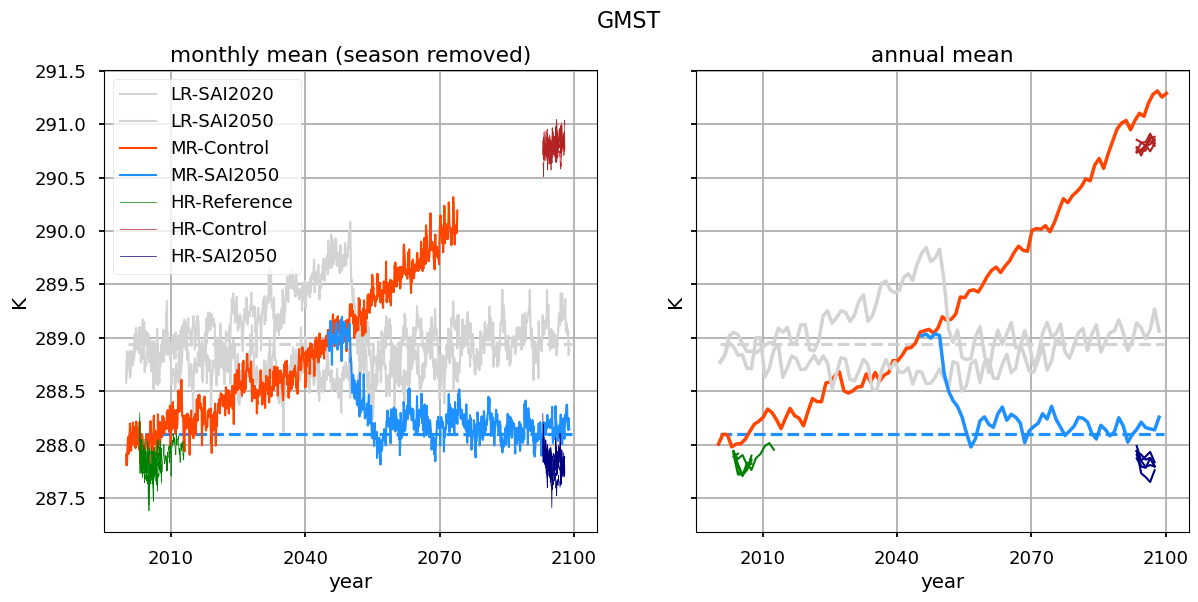

In [51]:
fig, axs = plt.subplots(1,2, figsize=(14,6), sharex=True, sharey=True)
fig.suptitle('GMST', fontsize=16)

# monthly mean plot
ax = axs[0]
ax.axhline(288.93796, xmin=0.05, xmax=0.95, ls='--', c='lightgray')
ax.axhline(288.09713, xmin=0.05, xmax=0.95, ls='--', c='dodgerblue')
for tag in VARgm: # only loop through experiments above
    if tag not in kwargs:
        continue
    shorttag = '.'.join(tag.split('.')[:3]) # tag without ensemble member
    gb = VARmgm[shorttag]
    (VARgm[tag].groupby('time.month')-(gb-gb.mean())).plot(ax=ax, **kwargs[tag])
ax.grid()
ax.set_xlabel('year')
ax.set_ylabel(VARgm['mres.cnt.h0'].units)
ax.set_title('monthly mean (season removed)')
ax.legend()

# annual mean plot
ax = axs[1]
ax.axhline(288.93796, xmin=0.05, xmax=0.95, ls='--', c='lightgray')
ax.axhline(288.09713, xmin=0.05, xmax=0.95, ls='--', c='dodgerblue')
for tag in VARgm: # only loop through experiments above
    if tag not in kwargs_avg:
        continue
    shorttag = '.'.join(tag.split('.')[:3]) # tag without ensemble member
    VARgm[tag].plot(ax=ax, **kwargs_avg[tag])
ax.grid()
ax.set_xlabel('year')
ax.set_ylabel(VARgm['mres.cnt.h0'].units)
ax.set_title('annual mean')
#ax.legend()

## CAM h0 -- maps

In [17]:
for k in cam:
    print(k, cam[k].time.min().item().strftime("%Y-%m-%d"), cam[k].time.max().item().strftime("%Y-%m-%d"))

mr-cnt 2000-02-15 2100-02-15
mr-sai 2045-01-16 2098-12-16
hr-sai.1 2092-12-16 2097-12-16
hr-sai.2 2092-12-16 2097-12-16
hr-sai.3 2092-12-16 2097-12-16
hr-sai.4 2092-12-16 2097-12-16
hr-spinup 2092-01-16 2092-11-16


Text(0.5, 0.98, '2092-12 - 2097-12')

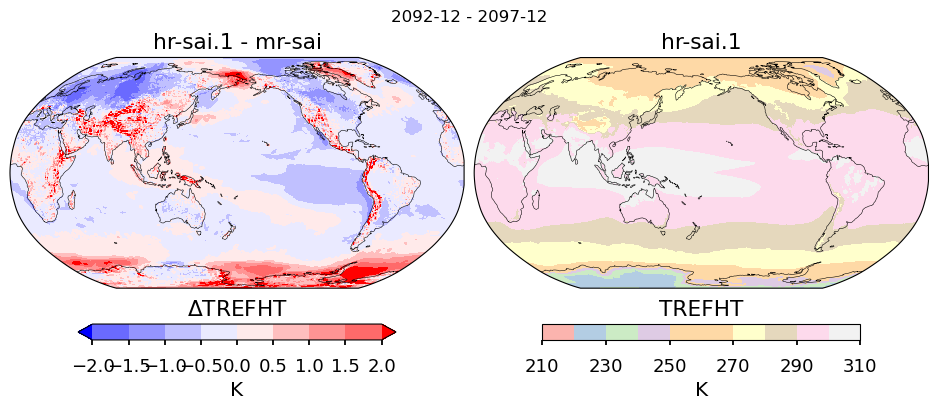

In [63]:
VAR = 'TREFHT'
tslice = slice('2092-12','2097-12')
dlevels = np.arange(-2,2.1,0.5) # levels of hr - mr difference plot
levels = range(210,311,10) # levels hr plot
mrname = 'mr-sai'
hrname = 'hr-sai.1'

Zmr = cam[mrname][VAR].sel(time=tslice).mean('time', keep_attrs=True)
Zhr = cam[hrname][VAR].sel(time=tslice).mean('time', keep_attrs=True)
Zdiff = Zhr.interp(lat=Zmr.lat, lon=Zmr.lon) - Zmr

#Y = (cam['hrt'][VAR].sel(time=tslice).interp(lat=cam['geo'].lat, lon=cam['geo'].lon) - cam['geo'][VAR].sel(time=tslice)).mean('time', keep_attrs=True)

fig,ax = plt.subplots(1,2, layout="compressed", figsize=(10,4), subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
pd = ax[0].contourf(Zdiff.lon, Zdiff.lat, Zdiff, levels=dlevels, cmap='bwr', transform=ccrs.PlateCarree(), extend='both',
                    norm=CenteredNorm(vcenter=0, halfrange=max(dlevels)*1.5))
ax[0].coastlines()
cb = fig.colorbar(pd, ax=ax[0], orientation='horizontal', shrink=.7, label=Zhr.units)
cb.ax.set_title(r"$\Delta$"+VAR)
ax[0].set_title(f'{hrname} - {mrname}')

ps = ax[1].contourf(Zhr.lon, Zhr.lat, Zhr, 
                    levels=levels, transform=ccrs.PlateCarree(), cmap='Pastel1')
ax[1].set_title(hrname)
ax[1].coastlines()
cb2 = fig.colorbar(ps, ax=ax[1], orientation='horizontal', shrink=.7, label=Zhr.units)
cb2.ax.set_title(VAR)
fig.suptitle(f"{tslice.start} - {tslice.stop}")

In [11]:
%%time
VAR = 'TREFHT'
tslice = slice('2045','2049')
Y = {
    'geo':(cam['geo'][VAR].sel(time=tslice).groupby('time.year').mean(keep_attrs=True).compute()),
    'cnt':(cam['cnt'][VAR].sel(time=tslice).groupby('time.year').mean(keep_attrs=True).compute()),
}
print('geo:',Y['geo'].year.min().data, Y['geo'].year.max().data)
print('cnt:',Y['cnt'].year.min().data, Y['cnt'].year.max().data)

sp = np.sqrt((Y['cnt'].std('year')**2+Y['geo'].std('year'))/2)
t = (Y['cnt'].mean('year') - Y['geo'].mean('year'))/(sp * np.sqrt(2/len(Y['geo'].year)))

geo: 2045 2049
cnt: 2045 2049
CPU times: user 315 ms, sys: 23.9 ms, total: 339 ms
Wall time: 1.98 s


Text(0.5, 0.28, 'geo - cnt\n(hatching: means are different p<0.05)')

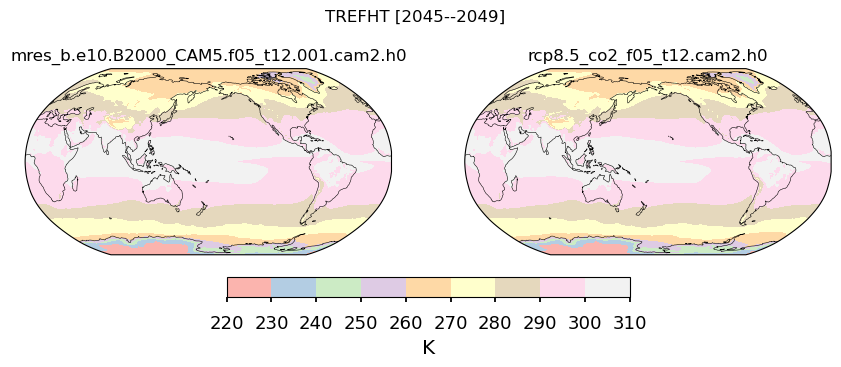

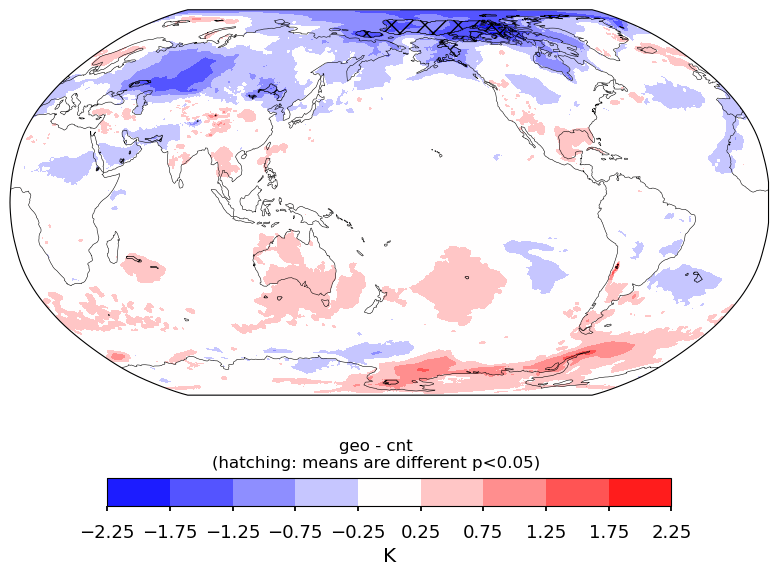

In [17]:
# Plot maps
levels = np.arange(220,311,10)
levels2 = np.linspace(-2.25,2.25,10)
cmap = 'Pastel1'
alpha = 2.776 # t value corresponding to p = 0.05

fig, ax = plt.subplots(1,2,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
p0 = ax[0].contourf(Y['geo'].lon, Y['geo'].lat, Y['geo'].mean('year'), levels=levels, cmap=cmap, transform=ccrs.PlateCarree())
ax[0].set_title('.'.join(os.path.basename(camg).split('.')[:-2]), fontsize=12)
ax[1].contourf(Y['cnt'].lon, Y['cnt'].lat, Y['cnt'].mean('year'), levels=levels, cmap=cmap, transform=ccrs.PlateCarree())
ax[1].set_title('.'.join(os.path.basename(camc).split('.')[:-2]), fontsize=12)
ax[0].coastlines()
ax[1].coastlines()
fig.colorbar(p0, ax=ax, orientation='horizontal', shrink=.5, pad=.04, label=Y['cnt'].units)
fig.suptitle(f"{VAR} [{tslice.start}--{tslice.stop}]",y=0.6)

fig2 = plt.figure()
ax2 = plt.axes(projection=ax[0].projection)
pd = ax2.contourf(Y['geo'].lon, Y['geo'].lat, (Y['geo']-Y['cnt']).mean('year'), levels=levels2, cmap='bwr', transform=ccrs.PlateCarree())
cs = ax2.contourf(t.lon, t.lat, (abs(t)>alpha).clip(min=0,max=1), levels=1, colors='k', hatches=['','\\//'], alpha=0, transform=ccrs.PlateCarree())
ct = ax2.contour(t.lon, t.lat, (abs(t)>alpha).clip(min=0,max=1), levels=[0.5], colors='k', linewidths=.5, transform=ccrs.PlateCarree())
ax2.coastlines()
fig2.colorbar(pd, ax=ax2, orientation='horizontal', shrink=.7, label=Y['geo'].units)
fig2.suptitle('geo - cnt\n(hatching: means are different p<0.05)', y=.28)